# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

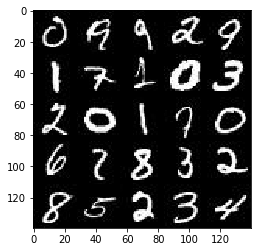

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

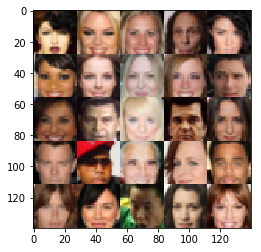

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_img_inputs = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels), name="real_img_inputs")
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name="z_inputs")
    lr = tf.placeholder(tf.float32, name="lr")
    
    return real_img_inputs,z_inputs,lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        #28x28xoutput_dim
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        x1 = tf.maximum(x1, x1*0.2)
        #14x14x128
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2*0.2)
        # 7x7x256
        
        # 4x4x512
        x3 = tf.layers.conv2d(x2, 512, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3*0.2)
        
        # remove one layer from discriminator
#         # 2x2x1024
        x4 = tf.layers.conv2d(x3, 1024, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(x4, x4*0.2)
    
        # flatten
        x5 = tf.reshape(x4, (-1,2*2*1024))
        logits = tf.layers.dense(x5, 1)
        out = tf.sigmoid(logits)
        

    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=(not is_train)):
        x1 = tf.layers.dense(z,2*2*512)
        x1 = tf.reshape(x1, (-1,2,2,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        #print(x1.shape)
        
        # 7x7x256
        x2 = tf.layers.conv2d_transpose(x1,256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        #print(x2.shape)
        
        # 14x14x128
        x3 = tf.layers.conv2d_transpose(x2,128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        #print(x3.shape)
        
        # 28x28xout
        x4 = tf.layers.conv2d_transpose(x3,out_channel_dim, 5, strides=2, padding='same')
        #print(x4.shape)
        
        out = tf.tanh(x4)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # get the logits
    gen_out = generator(input_z, out_channel_dim)
    d_out_real, d_logits_real = discriminator(images=input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(images=gen_out, reuse=True)
    
    
    # loss calculations
    smooth = 0.05
    labels_real = tf.ones_like(d_out_real) * (1 - smooth)
    labels_fake = tf.zeros_like(d_out_fake)
    labels_generator = tf.ones_like(d_out_fake)
    # discriminator loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=labels_real))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=labels_fake))
    d_loss = d_loss_real + d_loss_fake
    
    # generator loss 
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=labels_generator))
    

    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    all_trainable_vars = tf.trainable_variables()
    g_vars = [var for var in all_trainable_vars if var.name.startswith('generator')]
    d_vars = [var for var in all_trainable_vars if var.name.startswith('discriminator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    
    """
    # TODO: Build Model
    img_width = data_shape[1]
    img_height = data_shape[2]
    img_channels_count = data_shape[3]
    
    print("Image size ",img_width,"x",img_height,"x",img_channels_count)
    # build model 
    real_img_inputs, z_inputs, lr = model_inputs(img_width, img_height, img_channels_count, z_dim)
    d_loss, g_loss = model_loss(real_img_inputs, z_inputs, img_channels_count)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    steps = 0
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # because RGB value is in range of -0.5 to 0.5 while tanh is in range -1 to 1
                # need to adjust batch_images value here
                batch_images = batch_images * 2

                # generate random noise 
                batch_z = np.random.uniform(-1,1, size=(batch_size,z_dim))
               
                # train discriminator and generator together
                _ = sess.run(d_train_opt, feed_dict={real_img_inputs:batch_images, z_inputs:batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_inputs:batch_z, lr:learning_rate, real_img_inputs:batch_images})
                _ = sess.run(g_train_opt, feed_dict={z_inputs:batch_z, lr:learning_rate, real_img_inputs:batch_images})
                # now print loss every 100 iteration
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({z_inputs:batch_z,real_img_inputs:batch_images})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})
                    
                    print("Epoch ",epoch_i,
                          " ... Discri.Loss: ", train_loss_d, 
                          " Generator loss: ", train_loss_g )
                if steps % 100 == 0:    
                    show_generator_output(sess, 16, z_inputs, img_channels_count, data_image_mode)
        
        saver.save(sess, './saved_data.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [51]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Image size  28 x 28 x 1
Epoch  0  ... Discri.Loss:  2.43998  Generator loss:  0.183792


KeyboardInterrupt: 

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

### Batch 64

Image size  28 x 28 x 3
Epoch  0  ... Discri.Loss:  5.39682  Generator loss:  0.00780264
Epoch  0  ... Discri.Loss:  2.43253  Generator loss:  0.158845
Epoch  0  ... Discri.Loss:  1.76533  Generator loss:  0.294196
Epoch  0  ... Discri.Loss:  2.19067  Generator loss:  0.199112
Epoch  0  ... Discri.Loss:  2.16878  Generator loss:  1.85524
Epoch  0  ... Discri.Loss:  2.24627  Generator loss:  3.16099
Epoch  0  ... Discri.Loss:  1.6282  Generator loss:  0.422423
Epoch  0  ... Discri.Loss:  1.07594  Generator loss:  1.39167
Epoch  0  ... Discri.Loss:  1.48509  Generator loss:  0.400833
Epoch  0  ... Discri.Loss:  1.34112  Generator loss:  1.94593


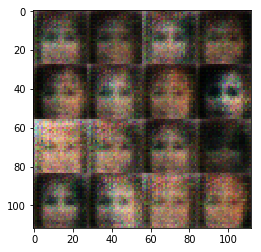

Epoch  0  ... Discri.Loss:  1.04923  Generator loss:  1.21274
Epoch  0  ... Discri.Loss:  1.2881  Generator loss:  0.819797
Epoch  0  ... Discri.Loss:  1.78166  Generator loss:  0.263239
Epoch  0  ... Discri.Loss:  1.5756  Generator loss:  1.0772
Epoch  0  ... Discri.Loss:  1.58035  Generator loss:  0.656621
Epoch  0  ... Discri.Loss:  1.40464  Generator loss:  0.59671
Epoch  0  ... Discri.Loss:  1.51604  Generator loss:  0.439631
Epoch  0  ... Discri.Loss:  1.40857  Generator loss:  0.627262
Epoch  0  ... Discri.Loss:  1.39674  Generator loss:  0.70082
Epoch  0  ... Discri.Loss:  1.38635  Generator loss:  0.748704


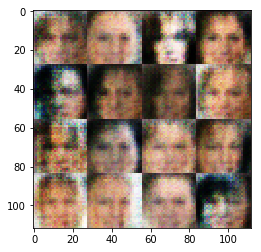

Epoch  0  ... Discri.Loss:  1.38364  Generator loss:  0.946817
Epoch  0  ... Discri.Loss:  1.67569  Generator loss:  1.60632
Epoch  0  ... Discri.Loss:  1.34755  Generator loss:  0.629242
Epoch  0  ... Discri.Loss:  1.38644  Generator loss:  0.931804
Epoch  0  ... Discri.Loss:  1.35446  Generator loss:  0.717427
Epoch  0  ... Discri.Loss:  1.36262  Generator loss:  0.756534
Epoch  0  ... Discri.Loss:  1.3836  Generator loss:  0.650394
Epoch  0  ... Discri.Loss:  1.35701  Generator loss:  1.05987
Epoch  0  ... Discri.Loss:  1.31947  Generator loss:  0.693403
Epoch  0  ... Discri.Loss:  1.32535  Generator loss:  1.12477


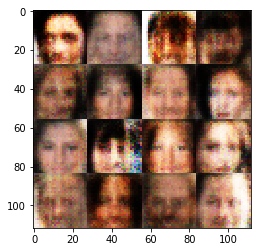

Epoch  0  ... Discri.Loss:  1.25864  Generator loss:  0.931481
Epoch  0  ... Discri.Loss:  1.6835  Generator loss:  0.335888
Epoch  0  ... Discri.Loss:  1.55834  Generator loss:  0.372463
Epoch  0  ... Discri.Loss:  1.43647  Generator loss:  0.444994
Epoch  0  ... Discri.Loss:  1.53519  Generator loss:  0.384103
Epoch  0  ... Discri.Loss:  1.37727  Generator loss:  0.62211
Epoch  0  ... Discri.Loss:  1.36068  Generator loss:  0.826339
Epoch  0  ... Discri.Loss:  1.65223  Generator loss:  0.346608
Epoch  0  ... Discri.Loss:  1.30006  Generator loss:  0.710958
Epoch  0  ... Discri.Loss:  1.37997  Generator loss:  0.521198


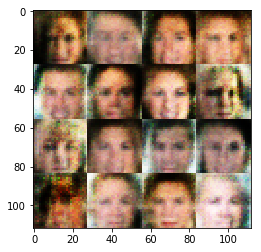

Epoch  0  ... Discri.Loss:  1.45574  Generator loss:  0.475207
Epoch  0  ... Discri.Loss:  1.28801  Generator loss:  0.833307
Epoch  0  ... Discri.Loss:  1.47717  Generator loss:  0.630637
Epoch  0  ... Discri.Loss:  1.38724  Generator loss:  1.06017
Epoch  0  ... Discri.Loss:  1.3065  Generator loss:  0.585415
Epoch  0  ... Discri.Loss:  1.57317  Generator loss:  1.49038
Epoch  0  ... Discri.Loss:  1.24206  Generator loss:  0.684874
Epoch  0  ... Discri.Loss:  1.51055  Generator loss:  0.46485
Epoch  0  ... Discri.Loss:  1.46431  Generator loss:  0.480411
Epoch  0  ... Discri.Loss:  1.40744  Generator loss:  0.533939


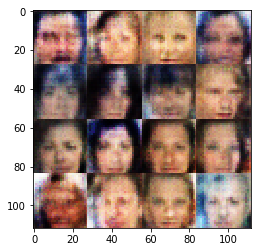

Epoch  0  ... Discri.Loss:  1.10576  Generator loss:  1.1832
Epoch  0  ... Discri.Loss:  1.45063  Generator loss:  0.506389
Epoch  0  ... Discri.Loss:  1.255  Generator loss:  0.731006
Epoch  0  ... Discri.Loss:  1.38392  Generator loss:  0.745154
Epoch  0  ... Discri.Loss:  1.72342  Generator loss:  0.313467
Epoch  0  ... Discri.Loss:  1.32012  Generator loss:  1.04886
Epoch  0  ... Discri.Loss:  1.29146  Generator loss:  0.607416
Epoch  0  ... Discri.Loss:  1.61037  Generator loss:  0.415479
Epoch  0  ... Discri.Loss:  1.45866  Generator loss:  1.36617
Epoch  0  ... Discri.Loss:  1.4359  Generator loss:  0.538682


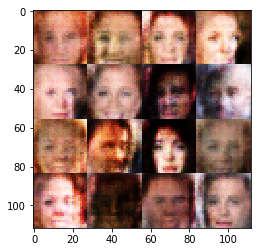

Epoch  0  ... Discri.Loss:  1.22088  Generator loss:  0.868681
Epoch  0  ... Discri.Loss:  1.20236  Generator loss:  0.728625
Epoch  0  ... Discri.Loss:  1.1976  Generator loss:  0.911052
Epoch  0  ... Discri.Loss:  1.39692  Generator loss:  1.16955
Epoch  0  ... Discri.Loss:  1.34836  Generator loss:  0.605173
Epoch  0  ... Discri.Loss:  1.36439  Generator loss:  1.32864
Epoch  0  ... Discri.Loss:  1.2884  Generator loss:  0.919819
Epoch  0  ... Discri.Loss:  1.32738  Generator loss:  0.70291
Epoch  0  ... Discri.Loss:  1.6195  Generator loss:  0.312507
Epoch  0  ... Discri.Loss:  1.41231  Generator loss:  0.575683


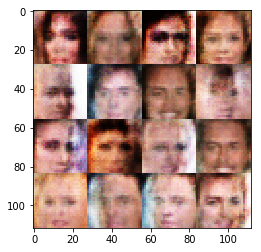

Epoch  0  ... Discri.Loss:  1.28278  Generator loss:  0.68969
Epoch  0  ... Discri.Loss:  1.47582  Generator loss:  0.443889
Epoch  0  ... Discri.Loss:  1.43717  Generator loss:  0.473974
Epoch  0  ... Discri.Loss:  1.39634  Generator loss:  0.507728
Epoch  0  ... Discri.Loss:  1.60883  Generator loss:  0.463974
Epoch  0  ... Discri.Loss:  1.3687  Generator loss:  0.458476
Epoch  0  ... Discri.Loss:  1.71978  Generator loss:  0.398155
Epoch  0  ... Discri.Loss:  1.36909  Generator loss:  0.642233
Epoch  0  ... Discri.Loss:  1.54859  Generator loss:  0.385091
Epoch  0  ... Discri.Loss:  1.39473  Generator loss:  0.621426


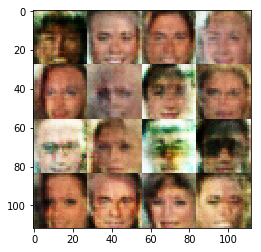

Epoch  0  ... Discri.Loss:  1.72631  Generator loss:  0.303934
Epoch  0  ... Discri.Loss:  1.52147  Generator loss:  0.384423
Epoch  0  ... Discri.Loss:  1.33295  Generator loss:  0.63082
Epoch  0  ... Discri.Loss:  1.47906  Generator loss:  0.476882
Epoch  0  ... Discri.Loss:  1.41009  Generator loss:  0.415094
Epoch  0  ... Discri.Loss:  1.5631  Generator loss:  0.376795
Epoch  0  ... Discri.Loss:  1.46398  Generator loss:  0.404679
Epoch  0  ... Discri.Loss:  1.44046  Generator loss:  0.59898
Epoch  0  ... Discri.Loss:  1.22976  Generator loss:  0.853976
Epoch  0  ... Discri.Loss:  1.29598  Generator loss:  0.722112


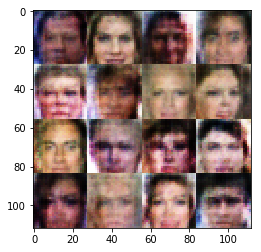

Epoch  0  ... Discri.Loss:  1.46684  Generator loss:  0.431317
Epoch  0  ... Discri.Loss:  1.46895  Generator loss:  0.687335
Epoch  0  ... Discri.Loss:  1.48169  Generator loss:  0.785391
Epoch  0  ... Discri.Loss:  1.36897  Generator loss:  0.622605
Epoch  0  ... Discri.Loss:  1.46924  Generator loss:  0.553056
Epoch  0  ... Discri.Loss:  1.47062  Generator loss:  0.435446
Epoch  0  ... Discri.Loss:  1.63406  Generator loss:  0.476509
Epoch  0  ... Discri.Loss:  1.31893  Generator loss:  1.08824
Epoch  0  ... Discri.Loss:  1.54204  Generator loss:  0.36605
Epoch  0  ... Discri.Loss:  1.33027  Generator loss:  0.693924


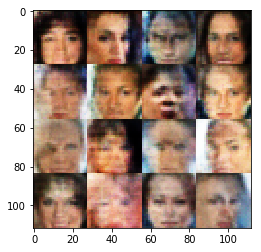

Epoch  0  ... Discri.Loss:  1.39033  Generator loss:  0.805211
Epoch  0  ... Discri.Loss:  1.5572  Generator loss:  0.366831
Epoch  0  ... Discri.Loss:  1.85282  Generator loss:  0.31587
Epoch  0  ... Discri.Loss:  1.46773  Generator loss:  1.30842
Epoch  0  ... Discri.Loss:  1.17605  Generator loss:  1.00313
Epoch  0  ... Discri.Loss:  1.3838  Generator loss:  0.699055
Epoch  0  ... Discri.Loss:  1.60703  Generator loss:  0.37502
Epoch  0  ... Discri.Loss:  1.44802  Generator loss:  0.485047
Epoch  0  ... Discri.Loss:  1.61183  Generator loss:  0.368243
Epoch  0  ... Discri.Loss:  1.47776  Generator loss:  0.560554


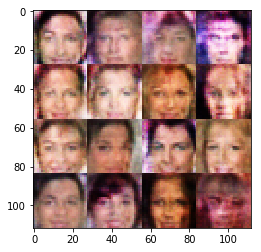

Epoch  0  ... Discri.Loss:  1.44416  Generator loss:  0.438946
Epoch  0  ... Discri.Loss:  1.60632  Generator loss:  0.380465
Epoch  0  ... Discri.Loss:  1.60892  Generator loss:  0.362579
Epoch  0  ... Discri.Loss:  1.57662  Generator loss:  0.577384
Epoch  0  ... Discri.Loss:  1.44045  Generator loss:  0.687631
Epoch  0  ... Discri.Loss:  1.81442  Generator loss:  0.312709
Epoch  0  ... Discri.Loss:  1.29865  Generator loss:  0.6545
Epoch  0  ... Discri.Loss:  1.34738  Generator loss:  0.721604
Epoch  0  ... Discri.Loss:  1.52579  Generator loss:  0.429927
Epoch  0  ... Discri.Loss:  1.77561  Generator loss:  0.277485


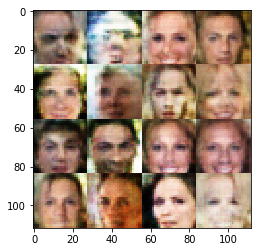

Epoch  0  ... Discri.Loss:  1.86074  Generator loss:  0.286661
Epoch  0  ... Discri.Loss:  1.30909  Generator loss:  0.68808
Epoch  0  ... Discri.Loss:  1.42854  Generator loss:  0.836367
Epoch  0  ... Discri.Loss:  1.45939  Generator loss:  0.460776
Epoch  0  ... Discri.Loss:  1.27267  Generator loss:  1.04798
Epoch  0  ... Discri.Loss:  1.52446  Generator loss:  0.518216
Epoch  0  ... Discri.Loss:  1.40137  Generator loss:  0.606959
Epoch  0  ... Discri.Loss:  1.63603  Generator loss:  0.512492
Epoch  0  ... Discri.Loss:  1.52659  Generator loss:  0.387004
Epoch  0  ... Discri.Loss:  1.59834  Generator loss:  0.342511


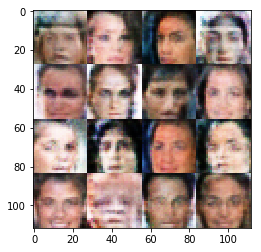

Epoch  0  ... Discri.Loss:  1.69341  Generator loss:  1.55356
Epoch  0  ... Discri.Loss:  1.4047  Generator loss:  0.640445
Epoch  0  ... Discri.Loss:  1.71295  Generator loss:  0.310129
Epoch  0  ... Discri.Loss:  1.52402  Generator loss:  0.387192
Epoch  0  ... Discri.Loss:  1.65086  Generator loss:  0.337218
Epoch  0  ... Discri.Loss:  1.36006  Generator loss:  0.624764
Epoch  0  ... Discri.Loss:  1.45581  Generator loss:  1.41637
Epoch  0  ... Discri.Loss:  1.34043  Generator loss:  0.592954
Epoch  0  ... Discri.Loss:  1.40384  Generator loss:  0.536491
Epoch  0  ... Discri.Loss:  1.28415  Generator loss:  0.558939


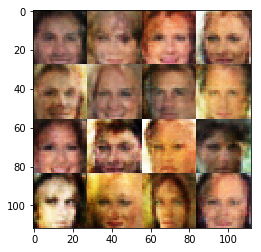

Epoch  0  ... Discri.Loss:  1.63869  Generator loss:  0.319609
Epoch  0  ... Discri.Loss:  2.02721  Generator loss:  0.248562
Epoch  0  ... Discri.Loss:  1.83122  Generator loss:  0.265485
Epoch  0  ... Discri.Loss:  1.74287  Generator loss:  0.275944
Epoch  0  ... Discri.Loss:  1.31077  Generator loss:  0.761592
Epoch  0  ... Discri.Loss:  1.40168  Generator loss:  0.703922
Epoch  0  ... Discri.Loss:  1.71073  Generator loss:  0.347977
Epoch  0  ... Discri.Loss:  1.51809  Generator loss:  0.49156
Epoch  0  ... Discri.Loss:  1.35323  Generator loss:  0.671171
Epoch  0  ... Discri.Loss:  1.58395  Generator loss:  0.418935


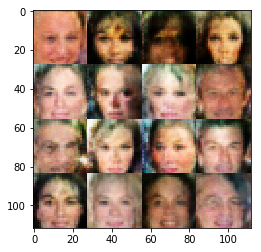

Epoch  0  ... Discri.Loss:  1.41668  Generator loss:  0.670049
Epoch  0  ... Discri.Loss:  1.6587  Generator loss:  0.315983
Epoch  0  ... Discri.Loss:  1.37294  Generator loss:  0.80384
Epoch  0  ... Discri.Loss:  1.52772  Generator loss:  0.474102
Epoch  0  ... Discri.Loss:  1.57867  Generator loss:  0.342562
Epoch  0  ... Discri.Loss:  1.50339  Generator loss:  0.473759
Epoch  0  ... Discri.Loss:  1.58813  Generator loss:  0.333167
Epoch  0  ... Discri.Loss:  1.63216  Generator loss:  0.327463
Epoch  0  ... Discri.Loss:  1.42688  Generator loss:  0.618923
Epoch  0  ... Discri.Loss:  1.49565  Generator loss:  0.566782


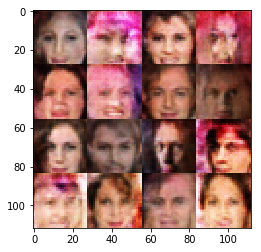

Epoch  0  ... Discri.Loss:  1.44077  Generator loss:  0.87002
Epoch  0  ... Discri.Loss:  1.56291  Generator loss:  0.395752
Epoch  0  ... Discri.Loss:  1.81545  Generator loss:  0.28289
Epoch  0  ... Discri.Loss:  1.33141  Generator loss:  1.21809
Epoch  0  ... Discri.Loss:  1.40464  Generator loss:  0.468751
Epoch  0  ... Discri.Loss:  1.31825  Generator loss:  0.593718
Epoch  0  ... Discri.Loss:  1.52031  Generator loss:  0.435784
Epoch  0  ... Discri.Loss:  1.41418  Generator loss:  0.500811
Epoch  0  ... Discri.Loss:  1.58623  Generator loss:  0.443197
Epoch  0  ... Discri.Loss:  1.45042  Generator loss:  0.462233


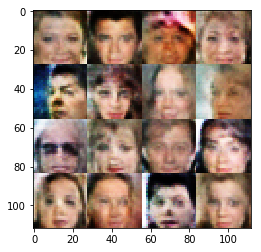

Epoch  0  ... Discri.Loss:  1.93428  Generator loss:  0.237714
Epoch  0  ... Discri.Loss:  1.37585  Generator loss:  0.620476
Epoch  0  ... Discri.Loss:  1.73407  Generator loss:  0.280394
Epoch  0  ... Discri.Loss:  1.83576  Generator loss:  0.272122
Epoch  0  ... Discri.Loss:  1.45244  Generator loss:  0.667827
Epoch  0  ... Discri.Loss:  1.43203  Generator loss:  0.454445
Epoch  0  ... Discri.Loss:  1.42249  Generator loss:  0.581997
Epoch  0  ... Discri.Loss:  1.36812  Generator loss:  0.518398
Epoch  0  ... Discri.Loss:  1.35374  Generator loss:  0.87567
Epoch  0  ... Discri.Loss:  1.69883  Generator loss:  0.335744


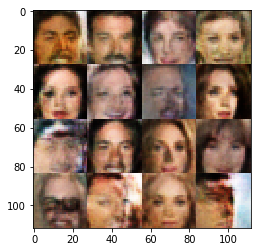

Epoch  0  ... Discri.Loss:  1.73516  Generator loss:  0.517133
Epoch  0  ... Discri.Loss:  1.67935  Generator loss:  0.289813
Epoch  0  ... Discri.Loss:  1.54761  Generator loss:  0.82066
Epoch  0  ... Discri.Loss:  1.47941  Generator loss:  0.692301
Epoch  0  ... Discri.Loss:  1.58118  Generator loss:  0.357818
Epoch  0  ... Discri.Loss:  1.84203  Generator loss:  0.291948
Epoch  0  ... Discri.Loss:  1.25289  Generator loss:  0.683701
Epoch  0  ... Discri.Loss:  1.37608  Generator loss:  0.511113
Epoch  0  ... Discri.Loss:  1.56662  Generator loss:  0.517198
Epoch  0  ... Discri.Loss:  1.193  Generator loss:  0.791718


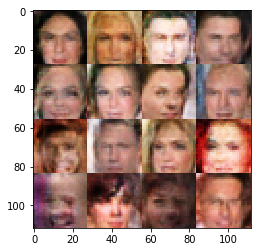

Epoch  0  ... Discri.Loss:  1.70543  Generator loss:  0.302348
Epoch  0  ... Discri.Loss:  1.76015  Generator loss:  0.254568
Epoch  0  ... Discri.Loss:  1.59816  Generator loss:  0.412205
Epoch  0  ... Discri.Loss:  1.52442  Generator loss:  0.452431
Epoch  0  ... Discri.Loss:  1.51384  Generator loss:  0.431342
Epoch  0  ... Discri.Loss:  1.58143  Generator loss:  1.10502
Epoch  0  ... Discri.Loss:  1.65547  Generator loss:  0.33953
Epoch  0  ... Discri.Loss:  1.58242  Generator loss:  1.41273
Epoch  0  ... Discri.Loss:  1.50477  Generator loss:  0.410488
Epoch  0  ... Discri.Loss:  1.57361  Generator loss:  0.381017


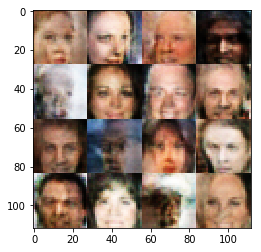

Epoch  0  ... Discri.Loss:  1.2037  Generator loss:  0.925197
Epoch  0  ... Discri.Loss:  1.41241  Generator loss:  0.475151
Epoch  0  ... Discri.Loss:  1.73259  Generator loss:  0.275204
Epoch  0  ... Discri.Loss:  1.22825  Generator loss:  0.825714
Epoch  0  ... Discri.Loss:  1.28431  Generator loss:  0.574706
Epoch  0  ... Discri.Loss:  1.63716  Generator loss:  0.370296
Epoch  0  ... Discri.Loss:  1.9211  Generator loss:  0.231808
Epoch  0  ... Discri.Loss:  1.61494  Generator loss:  0.35571
Epoch  0  ... Discri.Loss:  1.32427  Generator loss:  0.628205
Epoch  0  ... Discri.Loss:  1.36896  Generator loss:  1.17156


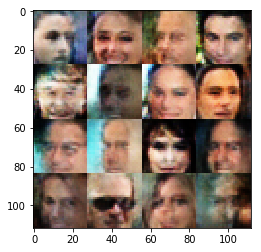

Epoch  0  ... Discri.Loss:  1.37515  Generator loss:  0.497595
Epoch  0  ... Discri.Loss:  2.0194  Generator loss:  0.202498
Epoch  0  ... Discri.Loss:  1.49069  Generator loss:  0.43246
Epoch  0  ... Discri.Loss:  1.6071  Generator loss:  0.383664
Epoch  0  ... Discri.Loss:  1.71646  Generator loss:  0.346838
Epoch  0  ... Discri.Loss:  1.74743  Generator loss:  0.274337
Epoch  0  ... Discri.Loss:  1.34259  Generator loss:  0.641451
Epoch  0  ... Discri.Loss:  1.61037  Generator loss:  0.356434
Epoch  0  ... Discri.Loss:  1.56759  Generator loss:  0.368946
Epoch  0  ... Discri.Loss:  1.49134  Generator loss:  0.573868


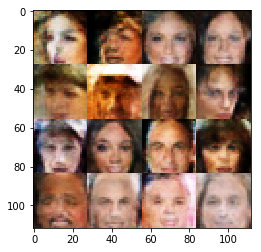

Epoch  0  ... Discri.Loss:  1.45989  Generator loss:  0.552711
Epoch  0  ... Discri.Loss:  1.51413  Generator loss:  0.364574
Epoch  0  ... Discri.Loss:  1.42057  Generator loss:  0.579893
Epoch  0  ... Discri.Loss:  1.53247  Generator loss:  0.723957
Epoch  0  ... Discri.Loss:  1.52975  Generator loss:  0.561998
Epoch  0  ... Discri.Loss:  1.89897  Generator loss:  0.233075
Epoch  0  ... Discri.Loss:  1.70792  Generator loss:  0.291877
Epoch  0  ... Discri.Loss:  1.77223  Generator loss:  0.272293
Epoch  0  ... Discri.Loss:  1.1527  Generator loss:  0.833087
Epoch  0  ... Discri.Loss:  1.35337  Generator loss:  0.649587


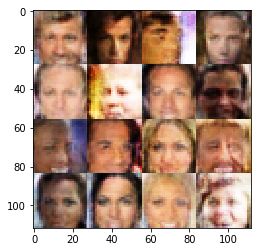

Epoch  0  ... Discri.Loss:  2.03757  Generator loss:  0.202911


KeyboardInterrupt: 

In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Batch 32

Image size  28 x 28 x 3
Epoch  0  ... Discri.Loss:  2.25981  Generator loss:  5.74514
Epoch  0  ... Discri.Loss:  1.35059  Generator loss:  1.66725
Epoch  0  ... Discri.Loss:  0.789873  Generator loss:  1.42651
Epoch  0  ... Discri.Loss:  1.17795  Generator loss:  0.59547
Epoch  0  ... Discri.Loss:  1.42529  Generator loss:  1.34284
Epoch  0  ... Discri.Loss:  1.611  Generator loss:  0.420556
Epoch  0  ... Discri.Loss:  1.30518  Generator loss:  0.614753
Epoch  0  ... Discri.Loss:  1.3542  Generator loss:  0.670266
Epoch  0  ... Discri.Loss:  1.90559  Generator loss:  0.247588
Epoch  0  ... Discri.Loss:  1.71939  Generator loss:  1.54786


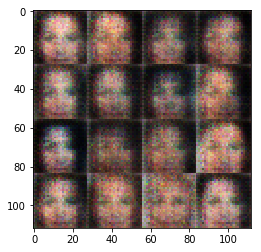

Epoch  0  ... Discri.Loss:  1.62828  Generator loss:  0.378026
Epoch  0  ... Discri.Loss:  1.49795  Generator loss:  1.09608
Epoch  0  ... Discri.Loss:  1.6034  Generator loss:  0.816606
Epoch  0  ... Discri.Loss:  1.44437  Generator loss:  0.740922
Epoch  0  ... Discri.Loss:  1.44558  Generator loss:  0.611973
Epoch  0  ... Discri.Loss:  1.72853  Generator loss:  0.386373
Epoch  0  ... Discri.Loss:  1.63883  Generator loss:  0.473552
Epoch  0  ... Discri.Loss:  1.64093  Generator loss:  0.358702
Epoch  0  ... Discri.Loss:  1.30331  Generator loss:  0.807577
Epoch  0  ... Discri.Loss:  1.61176  Generator loss:  0.398203


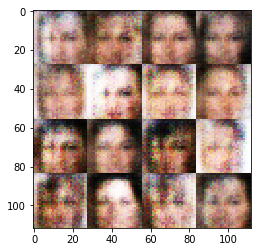

Epoch  0  ... Discri.Loss:  1.39641  Generator loss:  0.585103
Epoch  0  ... Discri.Loss:  1.45206  Generator loss:  0.674608
Epoch  0  ... Discri.Loss:  1.53605  Generator loss:  0.392491
Epoch  0  ... Discri.Loss:  1.2882  Generator loss:  0.768713
Epoch  0  ... Discri.Loss:  1.54422  Generator loss:  0.446422
Epoch  0  ... Discri.Loss:  1.33888  Generator loss:  0.519149
Epoch  0  ... Discri.Loss:  1.34385  Generator loss:  0.620384
Epoch  0  ... Discri.Loss:  1.39214  Generator loss:  0.533359
Epoch  0  ... Discri.Loss:  1.4458  Generator loss:  1.31488
Epoch  0  ... Discri.Loss:  1.29772  Generator loss:  0.697294


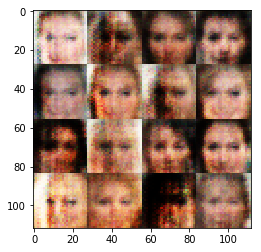

Epoch  0  ... Discri.Loss:  1.24163  Generator loss:  0.972427
Epoch  0  ... Discri.Loss:  1.37544  Generator loss:  0.798996
Epoch  0  ... Discri.Loss:  1.37987  Generator loss:  0.673718
Epoch  0  ... Discri.Loss:  1.32577  Generator loss:  0.60479
Epoch  0  ... Discri.Loss:  1.41213  Generator loss:  0.69713
Epoch  0  ... Discri.Loss:  1.61719  Generator loss:  0.387329
Epoch  0  ... Discri.Loss:  1.39724  Generator loss:  0.612821
Epoch  0  ... Discri.Loss:  1.27035  Generator loss:  0.641635
Epoch  0  ... Discri.Loss:  1.17658  Generator loss:  0.80556
Epoch  0  ... Discri.Loss:  1.44389  Generator loss:  0.524984


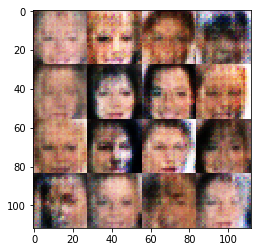

Epoch  0  ... Discri.Loss:  1.50074  Generator loss:  0.762685
Epoch  0  ... Discri.Loss:  1.22074  Generator loss:  0.974212
Epoch  0  ... Discri.Loss:  1.54453  Generator loss:  0.509268
Epoch  0  ... Discri.Loss:  1.17575  Generator loss:  0.840211
Epoch  0  ... Discri.Loss:  1.62707  Generator loss:  0.374518
Epoch  0  ... Discri.Loss:  1.72064  Generator loss:  0.312557
Epoch  0  ... Discri.Loss:  1.4104  Generator loss:  1.05004
Epoch  0  ... Discri.Loss:  1.29584  Generator loss:  0.642058
Epoch  0  ... Discri.Loss:  1.56636  Generator loss:  0.42394
Epoch  0  ... Discri.Loss:  1.32626  Generator loss:  0.60848


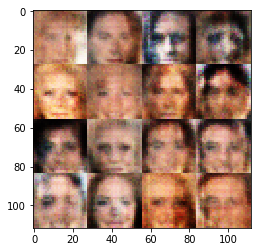

Epoch  0  ... Discri.Loss:  1.84836  Generator loss:  0.286942
Epoch  0  ... Discri.Loss:  1.53498  Generator loss:  0.495349
Epoch  0  ... Discri.Loss:  1.29853  Generator loss:  0.907919
Epoch  0  ... Discri.Loss:  1.5739  Generator loss:  1.20225
Epoch  0  ... Discri.Loss:  1.4675  Generator loss:  0.556058
Epoch  0  ... Discri.Loss:  1.51378  Generator loss:  1.06348
Epoch  0  ... Discri.Loss:  1.7497  Generator loss:  0.277296
Epoch  0  ... Discri.Loss:  1.5324  Generator loss:  0.450571
Epoch  0  ... Discri.Loss:  1.68505  Generator loss:  0.320233
Epoch  0  ... Discri.Loss:  1.40794  Generator loss:  0.578208


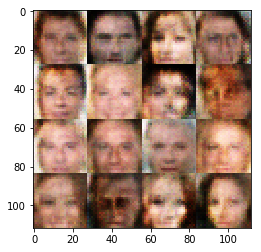

Epoch  0  ... Discri.Loss:  1.66274  Generator loss:  0.384356
Epoch  0  ... Discri.Loss:  1.31427  Generator loss:  0.627042
Epoch  0  ... Discri.Loss:  1.52306  Generator loss:  0.515146
Epoch  0  ... Discri.Loss:  1.84107  Generator loss:  0.328869
Epoch  0  ... Discri.Loss:  1.36364  Generator loss:  0.652925
Epoch  0  ... Discri.Loss:  1.60698  Generator loss:  0.375142
Epoch  0  ... Discri.Loss:  1.37218  Generator loss:  1.34286
Epoch  0  ... Discri.Loss:  1.48539  Generator loss:  0.484295
Epoch  0  ... Discri.Loss:  1.51483  Generator loss:  0.488652
Epoch  0  ... Discri.Loss:  1.56269  Generator loss:  0.392264


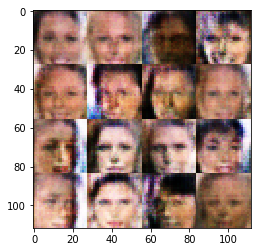

Epoch  0  ... Discri.Loss:  1.40302  Generator loss:  0.779394
Epoch  0  ... Discri.Loss:  1.76362  Generator loss:  0.289892
Epoch  0  ... Discri.Loss:  1.64228  Generator loss:  0.435321
Epoch  0  ... Discri.Loss:  1.47082  Generator loss:  1.47854
Epoch  0  ... Discri.Loss:  1.39323  Generator loss:  0.480109
Epoch  0  ... Discri.Loss:  1.47474  Generator loss:  0.514164
Epoch  0  ... Discri.Loss:  1.65481  Generator loss:  0.465469
Epoch  0  ... Discri.Loss:  1.23619  Generator loss:  0.568134
Epoch  0  ... Discri.Loss:  1.53187  Generator loss:  0.413787
Epoch  0  ... Discri.Loss:  1.42782  Generator loss:  0.52858


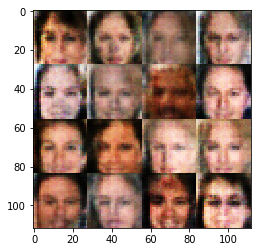

Epoch  0  ... Discri.Loss:  1.68124  Generator loss:  0.343399
Epoch  0  ... Discri.Loss:  1.61125  Generator loss:  0.391503
Epoch  0  ... Discri.Loss:  1.87748  Generator loss:  0.294727
Epoch  0  ... Discri.Loss:  1.69126  Generator loss:  0.337058
Epoch  0  ... Discri.Loss:  1.80366  Generator loss:  0.284342
Epoch  0  ... Discri.Loss:  1.69646  Generator loss:  0.350694
Epoch  0  ... Discri.Loss:  1.28757  Generator loss:  0.549929
Epoch  0  ... Discri.Loss:  1.41481  Generator loss:  0.692834
Epoch  0  ... Discri.Loss:  1.31681  Generator loss:  0.673219
Epoch  0  ... Discri.Loss:  1.87388  Generator loss:  0.356235


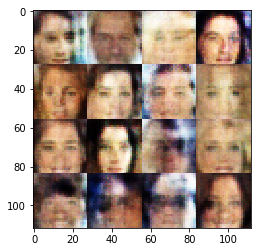

Epoch  0  ... Discri.Loss:  1.70844  Generator loss:  0.303065
Epoch  0  ... Discri.Loss:  1.50679  Generator loss:  0.490345
Epoch  0  ... Discri.Loss:  1.81772  Generator loss:  0.276153
Epoch  0  ... Discri.Loss:  1.76023  Generator loss:  0.347648
Epoch  0  ... Discri.Loss:  1.54038  Generator loss:  0.598924
Epoch  0  ... Discri.Loss:  1.63772  Generator loss:  0.362695
Epoch  0  ... Discri.Loss:  1.35706  Generator loss:  0.641843
Epoch  0  ... Discri.Loss:  1.75213  Generator loss:  0.275218
Epoch  0  ... Discri.Loss:  1.37107  Generator loss:  1.16933
Epoch  0  ... Discri.Loss:  1.43941  Generator loss:  0.579166


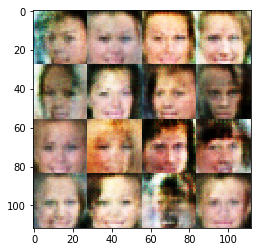

Epoch  0  ... Discri.Loss:  1.32543  Generator loss:  0.594067
Epoch  0  ... Discri.Loss:  1.43886  Generator loss:  0.478599
Epoch  0  ... Discri.Loss:  1.38166  Generator loss:  0.565522
Epoch  0  ... Discri.Loss:  1.59038  Generator loss:  0.474972
Epoch  0  ... Discri.Loss:  1.31849  Generator loss:  0.689644
Epoch  0  ... Discri.Loss:  1.26657  Generator loss:  0.697206
Epoch  0  ... Discri.Loss:  1.65555  Generator loss:  0.388161
Epoch  0  ... Discri.Loss:  1.66009  Generator loss:  0.337313
Epoch  0  ... Discri.Loss:  1.36974  Generator loss:  0.763734
Epoch  0  ... Discri.Loss:  1.37521  Generator loss:  0.551249


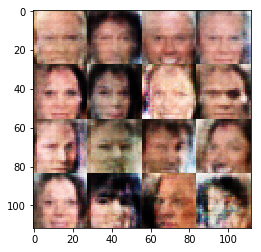

Epoch  0  ... Discri.Loss:  1.54968  Generator loss:  0.565863
Epoch  0  ... Discri.Loss:  1.61757  Generator loss:  0.374341
Epoch  0  ... Discri.Loss:  1.58894  Generator loss:  0.759821
Epoch  0  ... Discri.Loss:  1.57803  Generator loss:  0.382494
Epoch  0  ... Discri.Loss:  1.4747  Generator loss:  0.441404
Epoch  0  ... Discri.Loss:  1.40043  Generator loss:  1.08874
Epoch  0  ... Discri.Loss:  1.618  Generator loss:  0.350956
Epoch  0  ... Discri.Loss:  1.83399  Generator loss:  0.374492
Epoch  0  ... Discri.Loss:  1.42297  Generator loss:  1.1418
Epoch  0  ... Discri.Loss:  1.68066  Generator loss:  0.329488


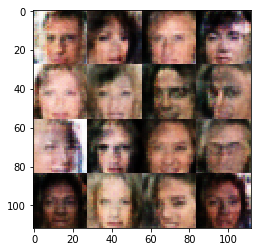

Epoch  0  ... Discri.Loss:  1.55841  Generator loss:  0.428692
Epoch  0  ... Discri.Loss:  1.22483  Generator loss:  0.982741
Epoch  0  ... Discri.Loss:  1.77671  Generator loss:  0.311355
Epoch  0  ... Discri.Loss:  1.31909  Generator loss:  0.574294
Epoch  0  ... Discri.Loss:  1.49893  Generator loss:  0.540717
Epoch  0  ... Discri.Loss:  1.48674  Generator loss:  0.479513
Epoch  0  ... Discri.Loss:  1.71919  Generator loss:  0.343651
Epoch  0  ... Discri.Loss:  1.67747  Generator loss:  0.327733
Epoch  0  ... Discri.Loss:  1.50882  Generator loss:  0.990383
Epoch  0  ... Discri.Loss:  2.3111  Generator loss:  0.168651


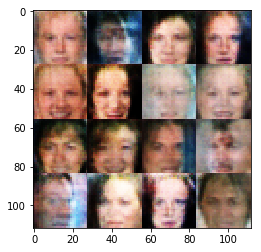

Epoch  0  ... Discri.Loss:  1.39274  Generator loss:  0.490439
Epoch  0  ... Discri.Loss:  1.60096  Generator loss:  0.485806
Epoch  0  ... Discri.Loss:  1.45812  Generator loss:  0.508402
Epoch  0  ... Discri.Loss:  1.43849  Generator loss:  0.547057
Epoch  0  ... Discri.Loss:  1.6127  Generator loss:  0.341837
Epoch  0  ... Discri.Loss:  1.64894  Generator loss:  0.362182
Epoch  0  ... Discri.Loss:  1.49482  Generator loss:  0.388525
Epoch  0  ... Discri.Loss:  1.54545  Generator loss:  0.409241
Epoch  0  ... Discri.Loss:  1.91546  Generator loss:  0.278293
Epoch  0  ... Discri.Loss:  1.85921  Generator loss:  0.245735


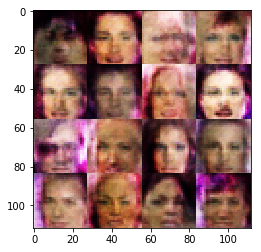

Epoch  0  ... Discri.Loss:  1.62707  Generator loss:  0.345343
Epoch  0  ... Discri.Loss:  1.54046  Generator loss:  0.387701
Epoch  0  ... Discri.Loss:  1.30213  Generator loss:  0.623306
Epoch  0  ... Discri.Loss:  1.1839  Generator loss:  1.01034
Epoch  0  ... Discri.Loss:  2.0002  Generator loss:  1.25286
Epoch  0  ... Discri.Loss:  2.27785  Generator loss:  0.190326
Epoch  0  ... Discri.Loss:  1.57575  Generator loss:  0.492491
Epoch  0  ... Discri.Loss:  1.72775  Generator loss:  0.313861
Epoch  0  ... Discri.Loss:  1.73244  Generator loss:  0.419298
Epoch  0  ... Discri.Loss:  1.5614  Generator loss:  0.429278


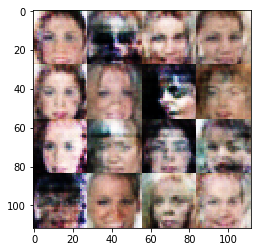

Epoch  0  ... Discri.Loss:  1.48536  Generator loss:  0.475913
Epoch  0  ... Discri.Loss:  1.53914  Generator loss:  0.373519
Epoch  0  ... Discri.Loss:  1.46363  Generator loss:  0.506829
Epoch  0  ... Discri.Loss:  1.59581  Generator loss:  0.341661
Epoch  0  ... Discri.Loss:  1.4849  Generator loss:  0.890956
Epoch  0  ... Discri.Loss:  1.49369  Generator loss:  0.483576
Epoch  0  ... Discri.Loss:  1.4407  Generator loss:  0.404126
Epoch  0  ... Discri.Loss:  1.61679  Generator loss:  0.351992
Epoch  0  ... Discri.Loss:  1.51975  Generator loss:  0.371465
Epoch  0  ... Discri.Loss:  1.61426  Generator loss:  0.429231


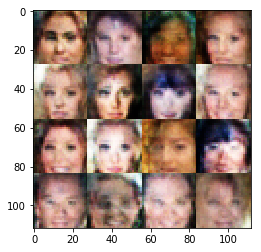

Epoch  0  ... Discri.Loss:  1.3872  Generator loss:  0.75162
Epoch  0  ... Discri.Loss:  1.88319  Generator loss:  0.259891
Epoch  0  ... Discri.Loss:  2.14506  Generator loss:  0.195118
Epoch  0  ... Discri.Loss:  1.74445  Generator loss:  0.511196
Epoch  0  ... Discri.Loss:  1.49928  Generator loss:  0.461071
Epoch  0  ... Discri.Loss:  1.9319  Generator loss:  0.2374
Epoch  0  ... Discri.Loss:  2.02183  Generator loss:  0.196298
Epoch  0  ... Discri.Loss:  1.99434  Generator loss:  0.226985
Epoch  0  ... Discri.Loss:  1.48821  Generator loss:  0.401059
Epoch  0  ... Discri.Loss:  1.4693  Generator loss:  0.451725


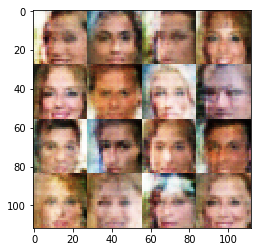

Epoch  0  ... Discri.Loss:  1.36588  Generator loss:  0.510417
Epoch  0  ... Discri.Loss:  1.31902  Generator loss:  0.546611
Epoch  0  ... Discri.Loss:  1.50219  Generator loss:  0.574547
Epoch  0  ... Discri.Loss:  1.97927  Generator loss:  0.246308
Epoch  0  ... Discri.Loss:  1.57881  Generator loss:  0.391811
Epoch  0  ... Discri.Loss:  1.62232  Generator loss:  0.326191
Epoch  0  ... Discri.Loss:  1.51488  Generator loss:  0.487462
Epoch  0  ... Discri.Loss:  1.38348  Generator loss:  0.604247
Epoch  0  ... Discri.Loss:  1.44565  Generator loss:  0.517521
Epoch  0  ... Discri.Loss:  1.65644  Generator loss:  0.413105


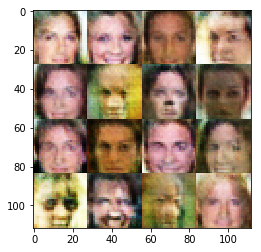

Epoch  0  ... Discri.Loss:  1.61085  Generator loss:  0.386495
Epoch  0  ... Discri.Loss:  1.81027  Generator loss:  0.283337
Epoch  0  ... Discri.Loss:  1.79385  Generator loss:  0.366275
Epoch  0  ... Discri.Loss:  1.45121  Generator loss:  0.626533
Epoch  0  ... Discri.Loss:  1.41701  Generator loss:  0.551635
Epoch  0  ... Discri.Loss:  1.37547  Generator loss:  1.01197
Epoch  0  ... Discri.Loss:  1.56732  Generator loss:  0.566118
Epoch  0  ... Discri.Loss:  1.54104  Generator loss:  1.14842
Epoch  0  ... Discri.Loss:  1.723  Generator loss:  0.295773
Epoch  0  ... Discri.Loss:  1.26544  Generator loss:  0.678846


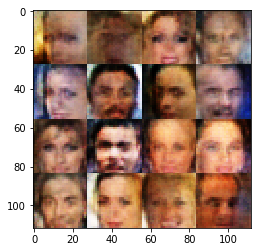

Epoch  0  ... Discri.Loss:  1.53003  Generator loss:  0.474337
Epoch  0  ... Discri.Loss:  1.49503  Generator loss:  0.546848
Epoch  0  ... Discri.Loss:  1.55  Generator loss:  0.378419
Epoch  0  ... Discri.Loss:  1.88648  Generator loss:  0.254124
Epoch  0  ... Discri.Loss:  1.21812  Generator loss:  0.642787
Epoch  0  ... Discri.Loss:  1.47438  Generator loss:  0.407952
Epoch  0  ... Discri.Loss:  2.20002  Generator loss:  0.163446
Epoch  0  ... Discri.Loss:  1.75  Generator loss:  0.40848
Epoch  0  ... Discri.Loss:  1.77794  Generator loss:  0.30567
Epoch  0  ... Discri.Loss:  1.77647  Generator loss:  0.289989


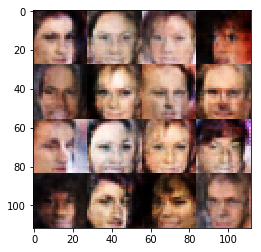

Epoch  0  ... Discri.Loss:  1.47124  Generator loss:  0.496727
Epoch  0  ... Discri.Loss:  1.47928  Generator loss:  0.938996
Epoch  0  ... Discri.Loss:  1.7642  Generator loss:  0.284904
Epoch  0  ... Discri.Loss:  2.18381  Generator loss:  0.166644
Epoch  0  ... Discri.Loss:  1.88793  Generator loss:  0.318613
Epoch  0  ... Discri.Loss:  1.85948  Generator loss:  0.260377
Epoch  0  ... Discri.Loss:  1.53202  Generator loss:  0.508362
Epoch  0  ... Discri.Loss:  1.89037  Generator loss:  0.227883
Epoch  0  ... Discri.Loss:  1.47064  Generator loss:  0.5682
Epoch  0  ... Discri.Loss:  1.27706  Generator loss:  0.593666


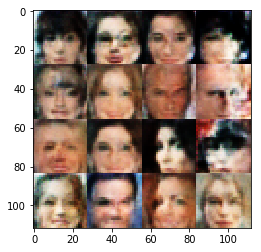

Epoch  0  ... Discri.Loss:  1.76819  Generator loss:  0.263537
Epoch  0  ... Discri.Loss:  1.68063  Generator loss:  0.328058
Epoch  0  ... Discri.Loss:  1.41396  Generator loss:  0.507884
Epoch  0  ... Discri.Loss:  1.5722  Generator loss:  0.384716
Epoch  0  ... Discri.Loss:  1.72014  Generator loss:  0.3092
Epoch  0  ... Discri.Loss:  1.74105  Generator loss:  0.277729
Epoch  0  ... Discri.Loss:  1.68575  Generator loss:  0.303352
Epoch  0  ... Discri.Loss:  1.85476  Generator loss:  0.261007
Epoch  0  ... Discri.Loss:  1.38893  Generator loss:  0.58829
Epoch  0  ... Discri.Loss:  1.77268  Generator loss:  0.290975


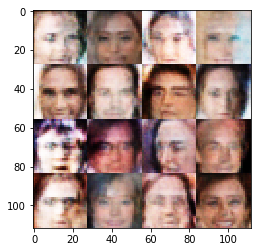

Epoch  0  ... Discri.Loss:  1.39128  Generator loss:  0.495906
Epoch  0  ... Discri.Loss:  1.63511  Generator loss:  0.356084
Epoch  0  ... Discri.Loss:  1.70822  Generator loss:  0.341465
Epoch  0  ... Discri.Loss:  2.23404  Generator loss:  0.162175
Epoch  0  ... Discri.Loss:  1.51648  Generator loss:  0.55095
Epoch  0  ... Discri.Loss:  2.31774  Generator loss:  0.148814
Epoch  0  ... Discri.Loss:  1.50165  Generator loss:  0.380636
Epoch  0  ... Discri.Loss:  1.37685  Generator loss:  0.625645
Epoch  0  ... Discri.Loss:  1.57963  Generator loss:  0.330107
Epoch  0  ... Discri.Loss:  1.34403  Generator loss:  1.26647


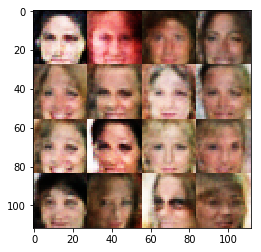

Epoch  0  ... Discri.Loss:  2.36397  Generator loss:  0.140428
Epoch  0  ... Discri.Loss:  1.398  Generator loss:  0.52322
Epoch  0  ... Discri.Loss:  1.45224  Generator loss:  0.429446
Epoch  0  ... Discri.Loss:  2.15017  Generator loss:  0.203723
Epoch  0  ... Discri.Loss:  1.62241  Generator loss:  0.366012
Epoch  0  ... Discri.Loss:  1.61492  Generator loss:  0.387231
Epoch  0  ... Discri.Loss:  2.20507  Generator loss:  0.159998
Epoch  0  ... Discri.Loss:  2.11007  Generator loss:  0.288228
Epoch  0  ... Discri.Loss:  1.7341  Generator loss:  0.372014
Epoch  0  ... Discri.Loss:  1.53248  Generator loss:  0.579225


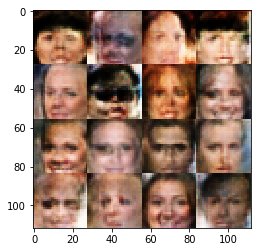

Epoch  0  ... Discri.Loss:  1.92699  Generator loss:  0.238673
Epoch  0  ... Discri.Loss:  1.54515  Generator loss:  0.385848
Epoch  0  ... Discri.Loss:  1.60868  Generator loss:  0.370627
Epoch  0  ... Discri.Loss:  1.83762  Generator loss:  0.285541
Epoch  0  ... Discri.Loss:  1.8343  Generator loss:  0.297832
Epoch  0  ... Discri.Loss:  1.48572  Generator loss:  0.547523
Epoch  0  ... Discri.Loss:  1.56789  Generator loss:  0.370416
Epoch  0  ... Discri.Loss:  1.97221  Generator loss:  0.291973
Epoch  0  ... Discri.Loss:  1.46266  Generator loss:  0.442424
Epoch  0  ... Discri.Loss:  1.21625  Generator loss:  0.627843


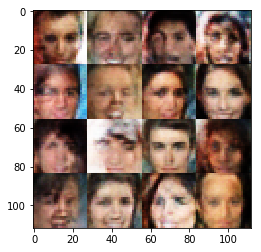

Epoch  0  ... Discri.Loss:  1.52231  Generator loss:  0.414595
Epoch  0  ... Discri.Loss:  1.53885  Generator loss:  0.408877
Epoch  0  ... Discri.Loss:  1.99247  Generator loss:  0.218213
Epoch  0  ... Discri.Loss:  1.80027  Generator loss:  0.279881
Epoch  0  ... Discri.Loss:  1.61665  Generator loss:  0.359785
Epoch  0  ... Discri.Loss:  1.93561  Generator loss:  0.242266
Epoch  0  ... Discri.Loss:  1.21649  Generator loss:  0.589352
Epoch  0  ... Discri.Loss:  1.60221  Generator loss:  0.503253
Epoch  0  ... Discri.Loss:  2.14323  Generator loss:  0.175648
Epoch  0  ... Discri.Loss:  1.74058  Generator loss:  0.285687


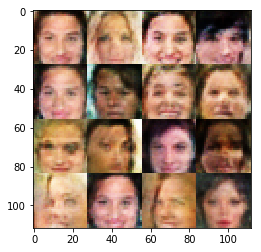

Epoch  0  ... Discri.Loss:  1.91544  Generator loss:  0.226175
Epoch  0  ... Discri.Loss:  1.8285  Generator loss:  0.262991
Epoch  0  ... Discri.Loss:  1.74381  Generator loss:  0.279148
Epoch  0  ... Discri.Loss:  1.74498  Generator loss:  0.308417
Epoch  0  ... Discri.Loss:  1.73755  Generator loss:  0.264988
Epoch  0  ... Discri.Loss:  1.6883  Generator loss:  1.1622
Epoch  0  ... Discri.Loss:  1.01876  Generator loss:  0.846024
Epoch  0  ... Discri.Loss:  1.81271  Generator loss:  0.278155
Epoch  0  ... Discri.Loss:  1.99542  Generator loss:  0.215175
Epoch  0  ... Discri.Loss:  2.03335  Generator loss:  0.211742


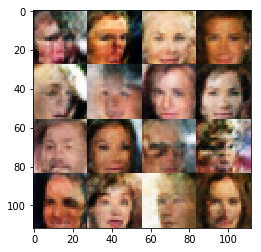

Epoch  0  ... Discri.Loss:  2.19869  Generator loss:  0.174047
Epoch  0  ... Discri.Loss:  1.88215  Generator loss:  0.239966
Epoch  0  ... Discri.Loss:  1.52068  Generator loss:  0.518233
Epoch  0  ... Discri.Loss:  1.52204  Generator loss:  0.577533
Epoch  0  ... Discri.Loss:  1.71596  Generator loss:  0.31278
Epoch  0  ... Discri.Loss:  1.59151  Generator loss:  0.453137
Epoch  0  ... Discri.Loss:  1.95026  Generator loss:  0.239177
Epoch  0  ... Discri.Loss:  1.6613  Generator loss:  0.302147
Epoch  0  ... Discri.Loss:  1.55186  Generator loss:  1.00113
Epoch  0  ... Discri.Loss:  1.25703  Generator loss:  0.560429


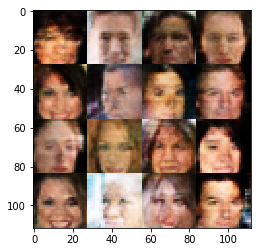

Epoch  0  ... Discri.Loss:  2.17216  Generator loss:  0.169609
Epoch  0  ... Discri.Loss:  2.08297  Generator loss:  0.191257
Epoch  0  ... Discri.Loss:  1.41109  Generator loss:  0.594651
Epoch  0  ... Discri.Loss:  1.80117  Generator loss:  0.284729
Epoch  0  ... Discri.Loss:  1.89824  Generator loss:  0.21612
Epoch  0  ... Discri.Loss:  1.61883  Generator loss:  0.373886
Epoch  0  ... Discri.Loss:  1.83941  Generator loss:  0.244296
Epoch  0  ... Discri.Loss:  1.42186  Generator loss:  0.469548
Epoch  0  ... Discri.Loss:  1.09546  Generator loss:  1.03086
Epoch  0  ... Discri.Loss:  1.75108  Generator loss:  0.286388


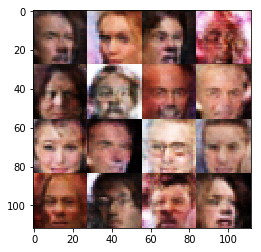

Epoch  0  ... Discri.Loss:  1.58817  Generator loss:  0.387938
Epoch  0  ... Discri.Loss:  1.89149  Generator loss:  0.278247
Epoch  0  ... Discri.Loss:  1.62389  Generator loss:  0.334181
Epoch  0  ... Discri.Loss:  1.89288  Generator loss:  0.256929
Epoch  0  ... Discri.Loss:  1.35854  Generator loss:  0.695846
Epoch  0  ... Discri.Loss:  2.15658  Generator loss:  0.184153
Epoch  0  ... Discri.Loss:  1.54559  Generator loss:  0.463415
Epoch  0  ... Discri.Loss:  1.69276  Generator loss:  0.367346
Epoch  0  ... Discri.Loss:  1.77281  Generator loss:  0.409644
Epoch  0  ... Discri.Loss:  1.47971  Generator loss:  0.515219


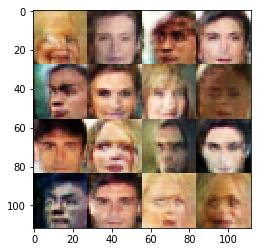

Epoch  0  ... Discri.Loss:  1.46252  Generator loss:  0.600563
Epoch  0  ... Discri.Loss:  1.81424  Generator loss:  0.260011
Epoch  0  ... Discri.Loss:  1.97938  Generator loss:  0.202098
Epoch  0  ... Discri.Loss:  1.56254  Generator loss:  0.462745
Epoch  0  ... Discri.Loss:  1.56394  Generator loss:  0.481676
Epoch  0  ... Discri.Loss:  1.61924  Generator loss:  0.347147
Epoch  0  ... Discri.Loss:  1.77683  Generator loss:  0.255043
Epoch  0  ... Discri.Loss:  1.61316  Generator loss:  0.381215
Epoch  0  ... Discri.Loss:  1.85841  Generator loss:  0.272973
Epoch  0  ... Discri.Loss:  1.55629  Generator loss:  0.352631


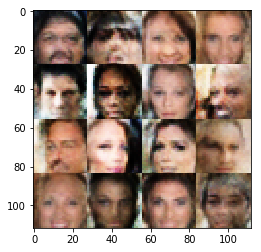

Epoch  0  ... Discri.Loss:  1.88828  Generator loss:  0.228655
Epoch  0  ... Discri.Loss:  1.661  Generator loss:  0.375767
Epoch  0  ... Discri.Loss:  1.50911  Generator loss:  0.469928
Epoch  0  ... Discri.Loss:  1.52077  Generator loss:  0.341507
Epoch  0  ... Discri.Loss:  2.02368  Generator loss:  0.205262
Epoch  0  ... Discri.Loss:  1.52037  Generator loss:  0.553427
Epoch  0  ... Discri.Loss:  1.58229  Generator loss:  0.358391
Epoch  0  ... Discri.Loss:  1.58582  Generator loss:  0.504296
Epoch  0  ... Discri.Loss:  1.79101  Generator loss:  0.373209
Epoch  0  ... Discri.Loss:  2.32939  Generator loss:  0.152458


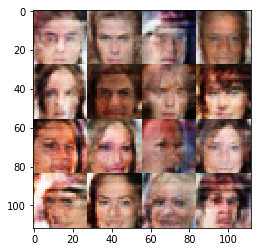

Epoch  0  ... Discri.Loss:  2.0697  Generator loss:  0.18523
Epoch  0  ... Discri.Loss:  1.73355  Generator loss:  0.265574
Epoch  0  ... Discri.Loss:  1.60127  Generator loss:  0.341732
Epoch  0  ... Discri.Loss:  1.92535  Generator loss:  0.247073
Epoch  0  ... Discri.Loss:  1.59894  Generator loss:  0.330517
Epoch  0  ... Discri.Loss:  1.64761  Generator loss:  0.312825
Epoch  0  ... Discri.Loss:  1.8389  Generator loss:  0.303303
Epoch  0  ... Discri.Loss:  1.49323  Generator loss:  0.47522
Epoch  0  ... Discri.Loss:  1.80082  Generator loss:  0.274472
Epoch  0  ... Discri.Loss:  1.56065  Generator loss:  0.50474


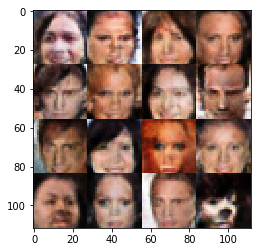

Epoch  0  ... Discri.Loss:  1.87187  Generator loss:  0.234978
Epoch  0  ... Discri.Loss:  1.45032  Generator loss:  0.412895
Epoch  0  ... Discri.Loss:  1.75053  Generator loss:  0.287393
Epoch  0  ... Discri.Loss:  1.54719  Generator loss:  0.408887
Epoch  0  ... Discri.Loss:  2.19638  Generator loss:  0.163766
Epoch  0  ... Discri.Loss:  1.34979  Generator loss:  0.636153
Epoch  0  ... Discri.Loss:  1.54052  Generator loss:  0.358648
Epoch  0  ... Discri.Loss:  1.08822  Generator loss:  0.923353
Epoch  0  ... Discri.Loss:  1.50558  Generator loss:  0.462257
Epoch  0  ... Discri.Loss:  1.81271  Generator loss:  0.277715


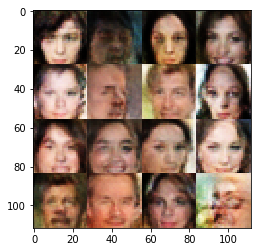

Epoch  0  ... Discri.Loss:  1.40892  Generator loss:  0.816547
Epoch  0  ... Discri.Loss:  1.47951  Generator loss:  0.408565
Epoch  0  ... Discri.Loss:  1.96604  Generator loss:  0.217042
Epoch  0  ... Discri.Loss:  1.52508  Generator loss:  1.18247
Epoch  0  ... Discri.Loss:  1.44453  Generator loss:  0.38921
Epoch  0  ... Discri.Loss:  1.68002  Generator loss:  0.366199
Epoch  0  ... Discri.Loss:  1.56908  Generator loss:  0.36697
Epoch  0  ... Discri.Loss:  1.3278  Generator loss:  0.715134
Epoch  0  ... Discri.Loss:  1.39397  Generator loss:  0.552882
Epoch  0  ... Discri.Loss:  1.57669  Generator loss:  0.715846


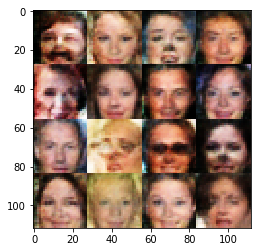

Epoch  0  ... Discri.Loss:  1.4234  Generator loss:  0.576176
Epoch  0  ... Discri.Loss:  1.50225  Generator loss:  0.582857
Epoch  0  ... Discri.Loss:  2.12599  Generator loss:  0.186628
Epoch  0  ... Discri.Loss:  1.38718  Generator loss:  0.672776
Epoch  0  ... Discri.Loss:  1.59797  Generator loss:  0.524466
Epoch  0  ... Discri.Loss:  1.78497  Generator loss:  0.273396
Epoch  0  ... Discri.Loss:  1.92421  Generator loss:  0.228153
Epoch  0  ... Discri.Loss:  2.05182  Generator loss:  0.212105
Epoch  0  ... Discri.Loss:  1.89076  Generator loss:  0.224194
Epoch  0  ... Discri.Loss:  1.60659  Generator loss:  0.352273


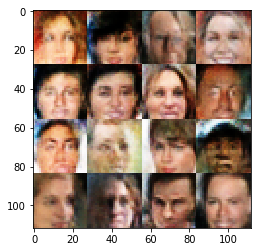

Epoch  0  ... Discri.Loss:  1.49768  Generator loss:  0.467977
Epoch  0  ... Discri.Loss:  1.83091  Generator loss:  0.309142
Epoch  0  ... Discri.Loss:  1.50768  Generator loss:  0.491682
Epoch  0  ... Discri.Loss:  1.29279  Generator loss:  0.483699
Epoch  0  ... Discri.Loss:  1.73879  Generator loss:  0.350551
Epoch  0  ... Discri.Loss:  1.58527  Generator loss:  0.510603
Epoch  0  ... Discri.Loss:  1.30012  Generator loss:  0.595059
Epoch  0  ... Discri.Loss:  1.69431  Generator loss:  0.335572
Epoch  0  ... Discri.Loss:  1.84801  Generator loss:  0.250671
Epoch  0  ... Discri.Loss:  1.80334  Generator loss:  0.245769


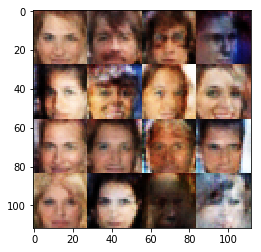

Epoch  0  ... Discri.Loss:  2.18273  Generator loss:  0.180452
Epoch  0  ... Discri.Loss:  2.00108  Generator loss:  0.211265
Epoch  0  ... Discri.Loss:  1.8339  Generator loss:  0.273939
Epoch  0  ... Discri.Loss:  1.89103  Generator loss:  0.242671
Epoch  0  ... Discri.Loss:  1.66808  Generator loss:  0.460366
Epoch  0  ... Discri.Loss:  2.23267  Generator loss:  0.171788
Epoch  0  ... Discri.Loss:  1.29542  Generator loss:  0.496551
Epoch  0  ... Discri.Loss:  1.91599  Generator loss:  0.234889
Epoch  0  ... Discri.Loss:  1.36249  Generator loss:  0.592033
Epoch  0  ... Discri.Loss:  1.97142  Generator loss:  0.20865


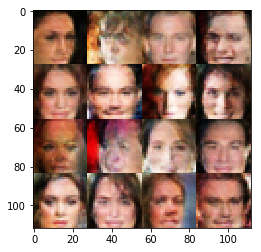

Epoch  0  ... Discri.Loss:  1.13049  Generator loss:  1.09768
Epoch  0  ... Discri.Loss:  2.00148  Generator loss:  0.204405
Epoch  0  ... Discri.Loss:  1.56709  Generator loss:  0.514197
Epoch  0  ... Discri.Loss:  1.58949  Generator loss:  0.463376
Epoch  0  ... Discri.Loss:  1.68923  Generator loss:  0.296678
Epoch  0  ... Discri.Loss:  1.61434  Generator loss:  0.394774
Epoch  0  ... Discri.Loss:  1.35237  Generator loss:  0.5515
Epoch  0  ... Discri.Loss:  1.66111  Generator loss:  0.396329
Epoch  0  ... Discri.Loss:  1.03557  Generator loss:  0.856563
Epoch  0  ... Discri.Loss:  1.90682  Generator loss:  0.274111


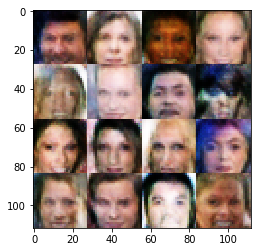

Epoch  0  ... Discri.Loss:  1.51312  Generator loss:  0.809462
Epoch  0  ... Discri.Loss:  1.28601  Generator loss:  0.45428
Epoch  0  ... Discri.Loss:  1.72017  Generator loss:  0.273713
Epoch  0  ... Discri.Loss:  2.15534  Generator loss:  0.173
Epoch  0  ... Discri.Loss:  1.85611  Generator loss:  0.236359
Epoch  0  ... Discri.Loss:  2.01428  Generator loss:  0.235886
Epoch  0  ... Discri.Loss:  1.60136  Generator loss:  0.356805
Epoch  0  ... Discri.Loss:  1.79914  Generator loss:  0.282252
Epoch  0  ... Discri.Loss:  1.55503  Generator loss:  0.478248
Epoch  0  ... Discri.Loss:  1.38056  Generator loss:  0.660321


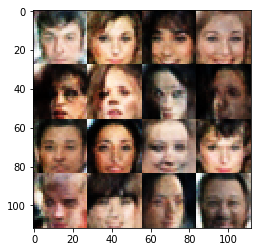

Epoch  0  ... Discri.Loss:  1.28353  Generator loss:  0.515365
Epoch  0  ... Discri.Loss:  1.57939  Generator loss:  0.356441
Epoch  0  ... Discri.Loss:  1.71126  Generator loss:  0.435373
Epoch  0  ... Discri.Loss:  1.77622  Generator loss:  0.298064
Epoch  0  ... Discri.Loss:  1.82526  Generator loss:  0.270305
Epoch  0  ... Discri.Loss:  1.56512  Generator loss:  0.357778
Epoch  0  ... Discri.Loss:  2.2145  Generator loss:  0.180561
Epoch  0  ... Discri.Loss:  1.77267  Generator loss:  0.258229
Epoch  0  ... Discri.Loss:  1.81635  Generator loss:  0.245139
Epoch  0  ... Discri.Loss:  1.65857  Generator loss:  1.86227


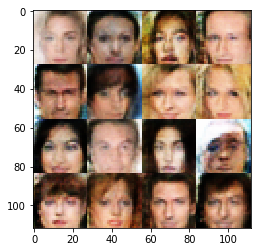

Epoch  0  ... Discri.Loss:  1.31343  Generator loss:  0.491969
Epoch  0  ... Discri.Loss:  2.02569  Generator loss:  0.222107
Epoch  0  ... Discri.Loss:  0.944848  Generator loss:  0.874275
Epoch  0  ... Discri.Loss:  1.45024  Generator loss:  0.572972
Epoch  0  ... Discri.Loss:  1.49484  Generator loss:  0.458502
Epoch  0  ... Discri.Loss:  2.07931  Generator loss:  0.189439
Epoch  0  ... Discri.Loss:  1.68905  Generator loss:  0.321297
Epoch  0  ... Discri.Loss:  1.79221  Generator loss:  0.279029
Epoch  0  ... Discri.Loss:  1.65481  Generator loss:  0.55521
Epoch  0  ... Discri.Loss:  1.67575  Generator loss:  0.314848


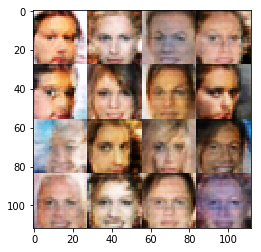

Epoch  0  ... Discri.Loss:  2.24458  Generator loss:  0.185412
Epoch  0  ... Discri.Loss:  1.85544  Generator loss:  0.232797
Epoch  0  ... Discri.Loss:  1.81061  Generator loss:  0.367529
Epoch  0  ... Discri.Loss:  1.45085  Generator loss:  0.541928


KeyboardInterrupt: 

In [17]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.